In [2]:
import numpy as np
import pandas as pd
import neurokit2 as nk
import joblib
import scipy.signal as signal
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [3]:
# 1. Load Sample PPG Signal from NeuroKit2

data = pd.read_csv("bio_resting_5min_100hz.csv")  # Ensure it's in the working directory
ppg_signal = data["PPG"]  # Adjust column name if needed
fs = 100   # Sampling rate

time = np.arange(len(ppg_signal)) / fs

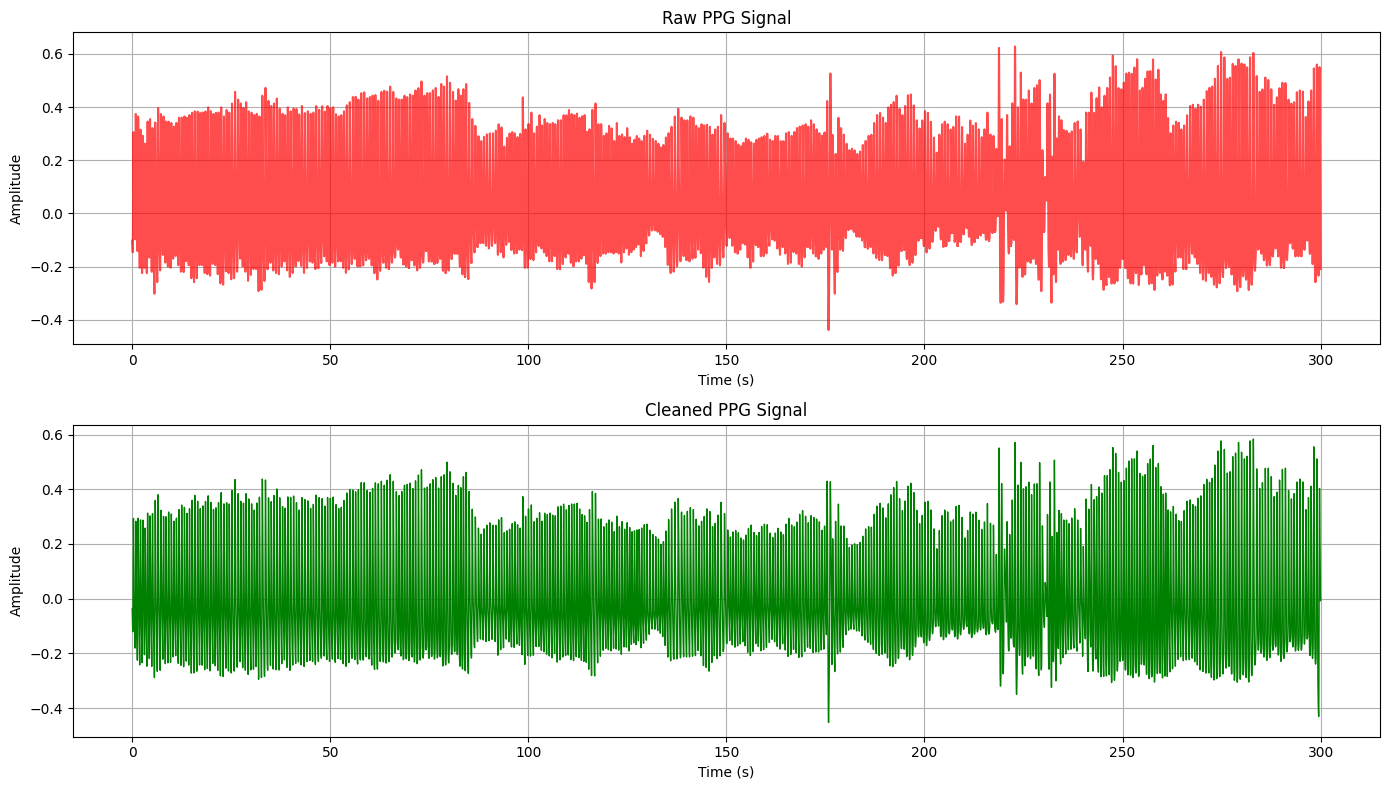

In [21]:
ppg_clean = nk.ppg_clean(ppg_signal, sampling_rate=fs)

# Plot raw and cleaned PPG signals in separate subplots
plt.figure(figsize=(14, 8))

# Plot Raw PPG
plt.subplot(2, 1, 1)
plt.plot(time, ppg_signal, color='Red', alpha=0.7)
plt.title("Raw PPG Signal")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.grid(True)

# Plot Cleaned PPG
plt.subplot(2, 1, 2)
plt.plot(time, ppg_clean, color='green', linewidth=1)
plt.title("Cleaned PPG Signal")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.grid(True)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

In [5]:
# 3. Feature Extraction
def extract_features(ppg_signal, fs):
    features = {}
    
    # Heart Rate (BPM)
    peaks, _ = signal.find_peaks(ppg_signal, distance=fs*0.6)
    rr_intervals = np.diff(peaks) / fs
    features["Heart_Rate"] = 60 / np.mean(rr_intervals) if len(rr_intervals) > 0 else np.nan
    features["PRV"] = np.std(rr_intervals) if len(rr_intervals) > 0 else np.nan

    # Power Spectral Density (Frequency Features)
    freqs, psd = signal.welch(ppg_signal, fs, nperseg=fs*2)
    features["Low_Freq_Power"] = np.sum(psd[(freqs >= 0.04) & (freqs < 0.15)])
    features["High_Freq_Power"] = np.sum(psd[(freqs >= 0.15) & (freqs < 0.4)])
    
    return features

features = extract_features(ppg_clean, fs)
features_df = pd.DataFrame([features]).dropna()
print("Extracted Features:")
print(features_df)

Extracted Features:
   Heart_Rate       PRV  Low_Freq_Power  High_Freq_Power
0   84.766708  0.083042             0.0              0.0


In [6]:
# 4. Create Synthetic Dataset for Classification
np.random.seed(42)
df = pd.DataFrame([extract_features(nk.ppg_clean(nk.signal_simulate(duration=10, sampling_rate=fs)), fs) for _ in range(500)]).dropna()
df['Label'] = np.random.choice([0, 1], size=len(df))  # 0 = Normal, 1 = Abnormal

In [7]:
# 5. Feature Scaling
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X = df.drop(columns=["Label"])
X_scaled = scaler.fit_transform(X)
y = df["Label"]
y

0      0
1      1
2      0
3      0
4      0
      ..
495    0
496    0
497    1
498    0
499    1
Name: Label, Length: 500, dtype: int32

In [8]:
# 6. Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [9]:
# 7. Train Model
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# # Save the trained model
joblib.dump(clf, "ppg_rf_model.pkl")
joblib.dump(scaler, "ppg_scaler.pkl")

['ppg_scaler.pkl']

In [10]:
# 8. Evaluate Model
y_pred = clf.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.47
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        53
           1       0.47      1.00      0.64        47

    accuracy                           0.47       100
   macro avg       0.23      0.50      0.32       100
weighted avg       0.22      0.47      0.30       100



c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


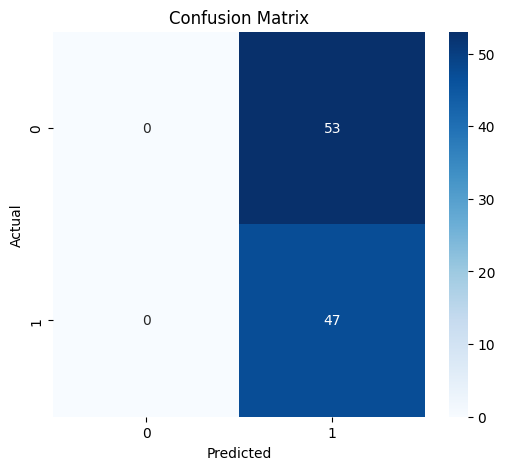

In [11]:
# Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [12]:
# 9. Load and Test on New Data
clf_loaded = joblib.load("ppg_rf_model.pkl")
scaler_loaded = joblib.load("ppg_scaler.pkl")

new_sample = extract_features(nk.ppg_clean(nk.signal_simulate(duration=10, sampling_rate=fs)), fs)
new_sample_df = pd.DataFrame([new_sample]).dropna()
new_sample_scaled = scaler_loaded.transform(new_sample_df)

prediction = clf_loaded.predict(new_sample_scaled)
print(f"New Sample Prediction: {'Abnormal' if prediction[0] == 1 else 'Normal'}")

New Sample Prediction: Abnormal


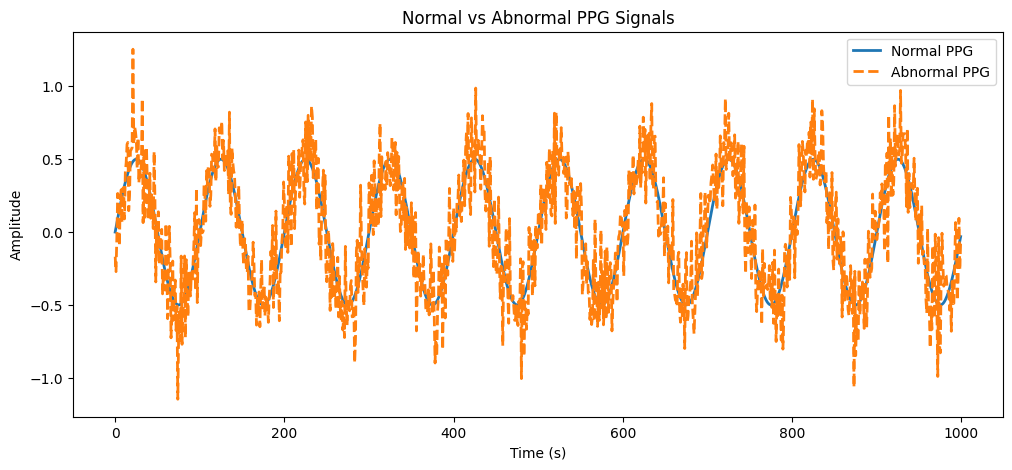

In [13]:
# Plot example of normal and abnormal signals
normal_sample = nk.signal_simulate(duration=10, sampling_rate=fs)
abnormal_sample = normal_sample + np.random.normal(0, 0.2, size=len(normal_sample))

plt.figure(figsize=(12, 5))
plt.plot(normal_sample, label='Normal PPG', linewidth=2)
plt.plot(abnormal_sample, label='Abnormal PPG', linewidth=2, linestyle='dashed')
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title("Normal vs Abnormal PPG Signals")
plt.legend()
plt.show()

Total Peak Count  127


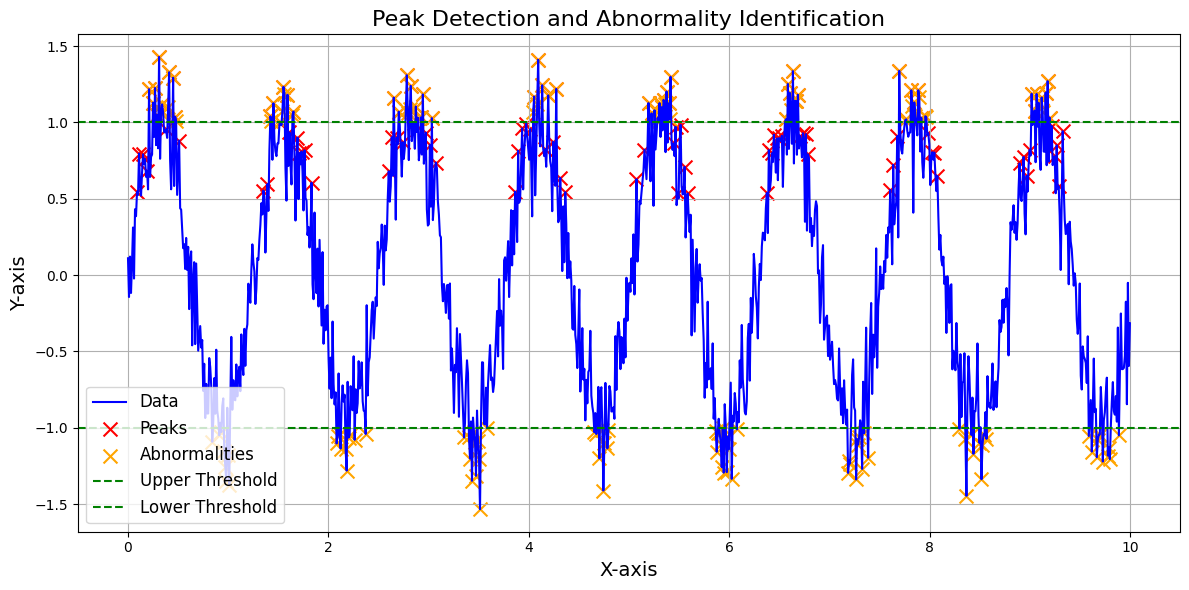

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

# Generate example data (sinusoidal data with random noise)
x = np.linspace(0, 10, 1000)  # X-axis values
y = np.sin(5 * x) + np.random.normal(0, 0.2, len(x))  # Y-axis values with noise

# Detect peaks using the find_peaks function
# 'height' defines the minimum height of a peak
peaks, properties = find_peaks(y, height=0.5)  # Adjust height as needed
peak_values = y[peaks]  # Get the y-values of the detected peaks

# Define abnormalities based on thresholds
# Example: Values greater than 1 or less than -1 are marked as abnormalities
abnormal_indices = np.where((y > 1) | (y < -1))[0]  # Indices of abnormalities
abnormal_values = y[abnormal_indices]  # Y-values of abnormalities
print('Total Peak Count ',len(peaks))

# Plot the data
plt.figure(figsize=(12, 6))
plt.plot(x, y, label="Data", color="blue", linewidth=1.5)  # Plot the main data
plt.scatter(x[peaks], peak_values, color="red", marker="x", s=100, label="Peaks")  # Mark peaks
plt.scatter(x[abnormal_indices], abnormal_values, color="orange", marker="x", s=100, label="Abnormalities")  # Mark abnormalities
plt.axhline(1, color="green", linestyle="--", label="Upper Threshold")  # Upper threshold line
plt.axhline(-1, color="green", linestyle="--", label="Lower Threshold")  # Lower threshold line

# Add plot details
plt.title("Peak Detection and Abnormality Identification", fontsize=16)
plt.xlabel("X-axis", fontsize=14)
plt.ylabel("Y-axis", fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()
